### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения

##### Студент:  Шалыгин Георгий
##### Группа:   НФИ-02

## Москва 2023
***

### Вариант № 22

Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).

 Набор данных: coil100 

 Диапазон классов: 51–55 

In [1]:
#!pip install -q tfds-nightly
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageOps

In [2]:
ds = tfds.load("coil100", split=['train[:80%]','train[80%:]'])
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])
df_train.shape, df_test.shape

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7200 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coil100/2.0.0.incompleteXGE29B/coil100-train.tfrecord*...:   0%|          …

Dataset coil100 downloaded and prepared to /root/tensorflow_datasets/coil100/2.0.0. Subsequent calls will reuse this data.


((5760, 4), (1440, 4))

In [3]:
df_train.head()

,angle,angle_label,image,object_id
0,20,4,"[[[53, 51, 32], [53, 51, 10], [25, 25, 25], [2...",23
1,315,63,"[[[53, 51, 32], [53, 51, 10], [26, 26, 26], [2...",4
2,100,20,"[[[53, 51, 32], [53, 51, 10], [25, 25, 25], [2...",57
3,15,3,"[[[53, 51, 32], [53, 51, 10], [26, 26, 26], [2...",45
4,145,29,"[[[53, 51, 32], [53, 51, 10], [25, 25, 25], [2...",69


In [4]:
df_train.iloc[0]['image'].shape

(128, 128, 3)

In [5]:
#оставим нужные классы
df_train = df_train[(df_train['angle_label'] >= 51) & (df_train['angle_label'] <= 55)]
df_test = df_test[(df_test['angle_label'] >= 51) & (df_test['angle_label'] <= 55)]
df_train.shape, df_test.shape

((392, 4), (108, 4))

In [117]:
train_labels = df_train['angle_label'].to_numpy(dtype=np.float32)
test_labels = df_test['angle_label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape

train_images = np.zeros(shape=(df_train.shape[0],128,128), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],128,128), dtype=np.float32)
train_images.shape, test_images.shape

for idx in range(train_labels.shape[0]):
    train_images[idx,:,:] = np.array(
        ImageOps.grayscale(Image.fromarray(df_train.iloc[idx]['image'])))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:] = np.array(
        ImageOps.grayscale(Image.fromarray(df_test.iloc[idx]['image'])))
    
train_images /= 255
test_images /= 255

train_images.shape, test_images.shape

((392, 128, 128), (108, 128, 128))

Визуализируем

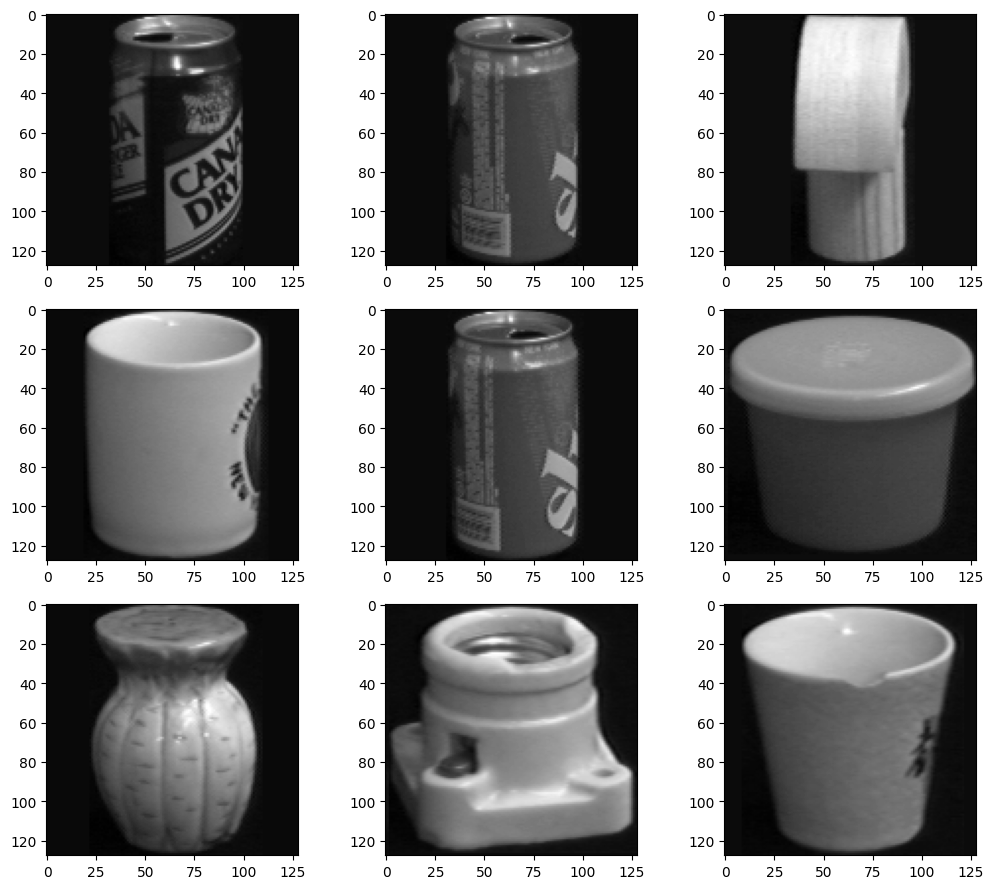

In [10]:
import random

def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)
    
    num_row = 3
    num_col = 3 

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i] 
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()

plot_random_sample(test_images)

2. Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений. 

 Архитектура нейросети: MLP 

 Показатель качества: cреднее квадратичное отклонение (MSE) для ошибки реконструкции 

 

In [23]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow import keras

import tensorflow as tf

In [169]:
input = Input(shape=train_images.shape[1:])
flat = Flatten()(input)

encoded = Dense(512, activation = 'relu')(flat)
encoded = Dense(128, activation = 'relu')(encoded)
decoded = Dense(512, activation = 'relu',
                    name = 'Encoded_Features')(encoded)
decoded = Dense(np.prod(train_images.shape[1:]))(decoded)
decoded = Reshape((train_images.shape[1:]))(decoded)

autoencoder = Model(input, decoded)
encoder = Model(input, encoded)

dec_inp = Input(shape=(128, ))
decoded_ = autoencoder.layers[-3](dec_inp)
decoded_ = autoencoder.layers[-2](decoded_)
decoded_ = autoencoder.layers[-1](decoded_)
decoder = Model(dec_inp, decoded_)

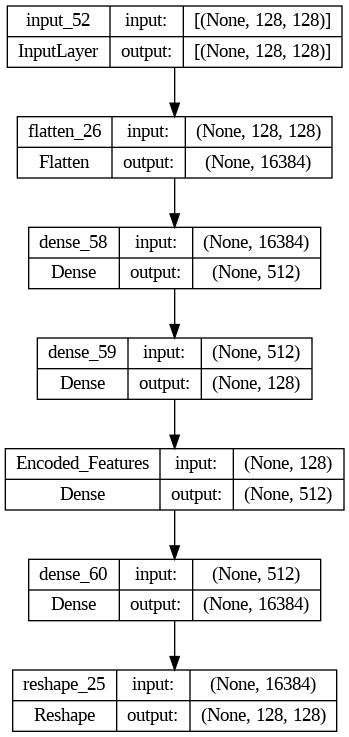

In [170]:
keras.utils.plot_model(autoencoder, show_shapes=True)

In [171]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [172]:
history = autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(test_images, test_images),
                verbose = 1);

Epoch 1/100
13/13 [==============================] - 3s 27ms/step - loss: 1.6767 - val_loss: 1.0280
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.9492 - val_loss: 0.8788
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.8490 - val_loss: 0.8200
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.7992 - val_loss: 0.7809
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7718 - val_loss: 0.7630
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7525 - val_loss: 0.7424
Epoch 7/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7364 - val_loss: 0.7314
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.7247 - val_loss: 0.7196
Epoch 9/100
13/13 [==============================] - 0s 10ms/step - loss: 0.7135 - val_loss: 0.7124
Epoch 10/100
13/13 [==============================] - 0s 11ms/step - loss: 0.7058 - val_loss: 0.7028

In [173]:
encoded_imgs = encoder.predict(test_images)
decoded_imgs = decoder.predict(encoded_imgs)

4/4 [==============================] - 0s 2ms/step


In [174]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 10  # кол-во изображений
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)    

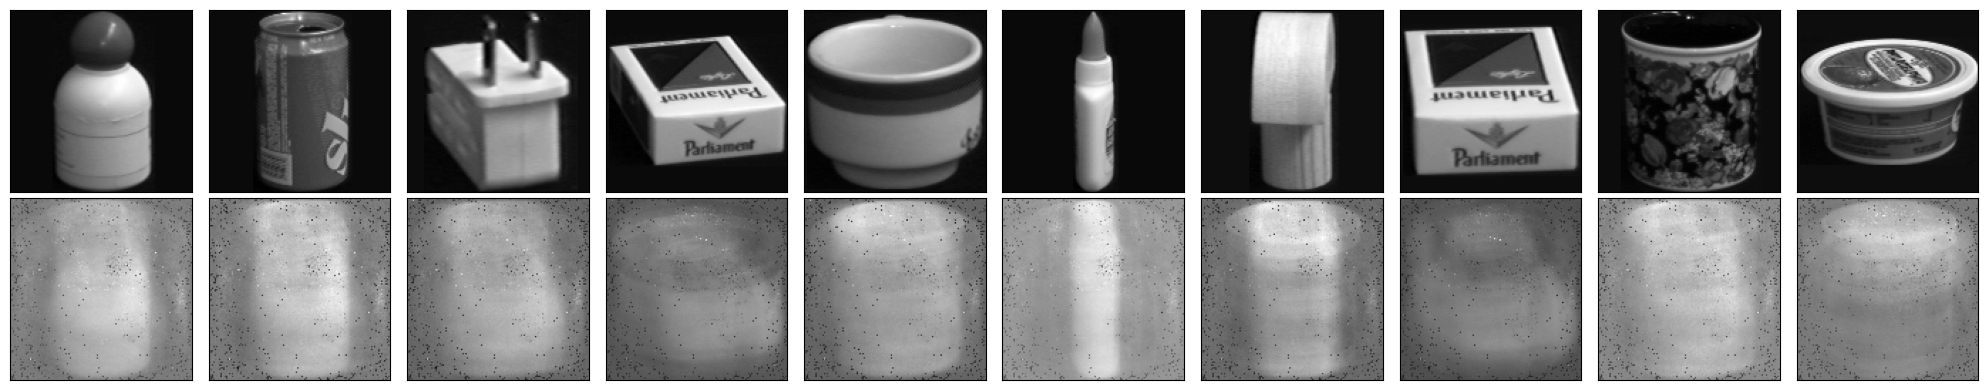

In [175]:
image_show(test_images, decoded_imgs)

Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.
 
 MSE

In [176]:
mse = np.mean((test_images - autoencoder.predict(test_images))**2)
print('TestMSE = ', mse)

4/4 [==============================] - 0s 3ms/step
TestMSE =  0.023678526



Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми.

In [177]:
train_images2 = train_images[train_labels < 53]
train_labels2 = train_labels[train_labels < 53]
test_images2 = test_images[test_labels < 53]
test_labels2 = test_labels[test_labels < 53]

In [179]:
test_images2.shape

(39, 128, 128)

Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

In [206]:
#первые признаки равны 0, взял не равные
xtr = encoder.predict(train_images2)[:, -1]
ytr = encoder.predict(train_images2)[:, -13]
xte = encoder.predict(test_images2)[:, -1]
yte = encoder.predict(test_images2)[:, -13]


2/2 [==============================] - 0s 7ms/step


Text(0, 0.5, 'Признак -13')

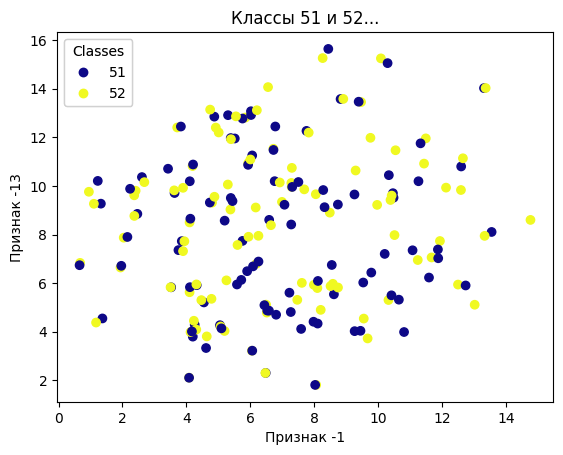

In [212]:
fig, ax = plt.subplots()
scatter = ax.scatter(xtr, ytr, c=train_labels2, cmap='plasma')
scatter = ax.scatter(xte, yte, c=test_labels2, cmap='plasma')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('Классы 51 и 52...')
plt.xlabel('Признак -1')
plt.ylabel('Признак -13')

Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов

In [235]:
from sklearn.neighbors import KNeighborsClassifier 


encoded_train = encoder.predict(train_images2)
encoded_test = encoder.predict(test_images2)

labels_test = test_labels2
labels_test[labels_test == 51] = 0
labels_test[labels_test == 52] = 1

labels_train = train_labels2
labels_train[labels_train == 51] = 0
labels_train[labels_train == 52] = 1

knn = KNeighborsClassifier(n_neighbors=7).fit(encoded_train, 
                                              labels_train) 

# доля верных ответов на X_test 
accuracy = knn.score(encoded_test, labels_test)

knn_big = KNeighborsClassifier(n_neighbors=7).fit(train_images2.reshape((train_images2.shape[0], -1)), 
                                              labels_train)

# доля верных ответов на X_test 
accuracy2 = knn_big.score(test_images2.reshape((test_images2.shape[0], -1)), labels_test) 
print (accuracy, accuracy2)

2/2 [==============================] - 0s 4ms/step
0.41025641025641024 0.38461538461538464


Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).

In [242]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = knn.predict_proba(encoded_test)
pred_prob2 = knn_big.predict_proba(test_images2.reshape((test_images2.shape[0], -1)))

fpr1, tpr1, thresholds1 = roc_curve(labels_test, pred_prob1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(labels_test, pred_prob2[:, 1])

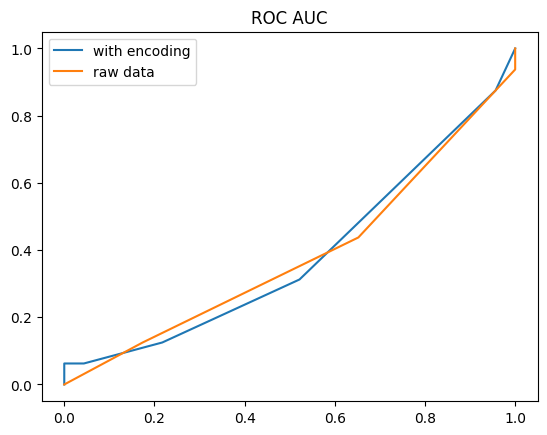

In [247]:
plt.plot(fpr1, tpr1, label='with encoding')
plt.plot(fpr2, tpr2, label='raw data')
plt.title('ROC AUC')
plt.legend()

Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).

In [263]:
xmin = min(encoded_train[:, -1].min(), encoded_test[:, -1].min())
xmax = max(encoded_train[:, -1].max(), encoded_test[:, -1].max())
ymin = min(encoded_train[:, -13].min(), encoded_test[:, -13].min())
ymax = max(encoded_train[:, -13].max(), encoded_test[:, -13].max())
xdelta = abs(xmax - xmin) * 0.1
x = np.linspace(xmin-xdelta, xmax+xdelta, 50)
ydelta = abs(ymax - ymin) * 0.1
y = np.linspace(ymin-ydelta, ymax+ydelta, 50)
x, y = np.meshgrid(x, y)
# shape_ = x.shape
# X_ = np.column_stack((x.ravel(), y.ravel()))
# y_pred = np.round(autoencoder.predict(X_))
# y_pred = y_pred.reshape(x.shape)
# plt.contourf(x, y, y_pred, cmap=plt.cm.RdYlBu, alpha=0.5)
X = np.zeros((len(x.ravel()), 128))
means_ = (encoded_test.mean(axis=0) + encoded_train.mean(axis=0)) / 2
for i in range(len(X)):
  X[i] = means_
X[:, -1] = x.ravel()
X[:, -13] = y.ravel()

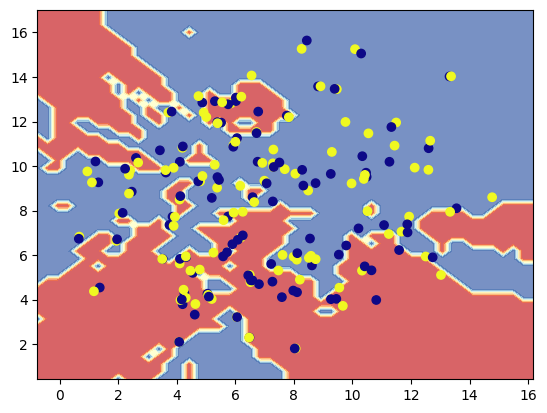

In [275]:
pred = knn.predict(X)
pred = pred.reshape(x.shape)
plt.contourf(x, y, pred, cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(xtr, ytr, c=train_labels2, cmap='plasma')
plt.scatter(xte, yte, c=test_labels2, cmap='plasma')

Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.

In [292]:
RE = ((test_images.reshape(108, 128*128) - decoded_imgs.reshape(108, 128*128))**2).mean(axis = 1)
biggest_re_pos = np.argmax(RE)

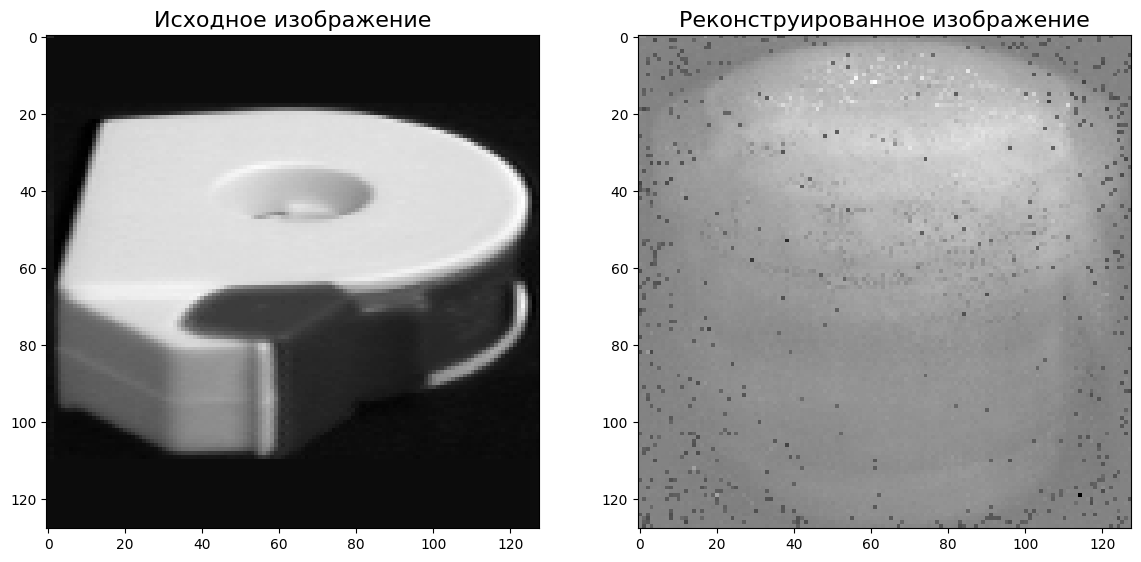

In [294]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
ax.imshow(test_images[biggest_re_pos].reshape(128, 128))

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
ax.imshow(decoded_imgs[biggest_re_pos].reshape(128, 128));